# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt
import joblib

In [ ]:
# Load training data
train_transaction =  dt.fread("dataset/train_transaction.csv").to_pandas()
train_identity = dt.fread("dataset/train_identity.csv").to_pandas()

In [4]:
# Merge the two files into one training set
trainset = pd.merge(train_transaction, train_identity, on='TransactionID', how='outer')
%reset_selective -f train_transaction
%reset_selective -f train_identity

In [5]:
# Use only selective columns
trainset = trainset[["TransactionID","DeviceType","DeviceInfo","TransactionDT","TransactionAmt","ProductCD","card4","card6","P_emaildomain","R_emaildomain","addr1","addr2","dist1","dist2","isFraud"]]

In [ ]:
# Convert date time field into meaningful fields
trainset['TransactionDT_day'] = trainset['TransactionDT'].apply(lambda x: int(x/86400)) # Day count
trainset['TransactionDT_hour'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24)) # Hour of the day
trainset['TransactionDT_min'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24%1*60)) # Minute of the hour
trainset['TransactionDT_sec'] = trainset['TransactionDT'].apply(lambda x: int(x/86400%1*24%1*60%1*60)) # Seconds of the minute

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

#### Plot [histogram$^{[1]}$](#References) of all the numerical fields for both fraudulent and non-fraudulent transactions and comparing the graphs:

In [1]:
hist = trainset[trainset['isFraud'] == True][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].hist(grid=False, figsize=(24,16), color='#86bf91', zorder=2, rwidth=0.9)

In [ ]:
hist = trainset[trainset['isFraud'] == False][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].hist(grid=False, figsize=(24,16), color='#86bf91', zorder=2, rwidth=0.9)

#### Comparing the histograms above we can make the following observations: 

- `TransactionAmt`: The transaction amounts are high for both fraud and non-fraud transactions. Amounts seem to be slightly distributed for fraud transactions while for non fraud transactions high frequency of high amounts of transactions completely skew the histogram. This feature might be useful in prediction because of the difference in distributions
- `TransactionDT`: The transactions seem fairly evenly distributed across all days for fraudulent transactions. Similarly for non fraud transactions, only the initial days have slightly higher number of transactions while the rest of the days have even distributions.
- `TransactionID`: Since this is an ID field providing identity for transactions, it is evenly distributed for non-fraud transactions. Fraudulent transactions also occur randomly across IDs revealing no pattern.
- `addr1`, `addr2`: Both the address fields have similar histograms for fraud and non fraud transactions. The addr2 field is heavily dominated by a particular value with a single peak in the graph. This field does not seem to be a useful feature for the prediction model.
- `dist1`, `dist2`: The distance fields also show domination by a particular value and might not be useful. For fraud transactions slight higher frequencies are observed for other values but that may be because of the low frequency of fraudulent transactions.

In [10]:
trainset[trainset['isFraud'] == True][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000


In [12]:
trainset[trainset['isFraud'] == False][["TransactionID","TransactionDT","TransactionAmt","addr1","addr2","dist1","dist2"]].describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000


In [7]:
trainset.groupby('isFraud').agg([np.mean, np.median])

TransactionID          TransactionDT          TransactionAmt         \
                 mean   median          mean   median           mean median   
isFraud                                                                       
False    3.281810e+06  3281808  7.360791e+06  7271678     134.511665   68.5   
True     3.294952e+06  3291934  7.690033e+06  7575230     149.244779   75.0   

              addr1             addr2              dist1              dist2  \
               mean median       mean median        mean median        mean   
isFraud                                                                       
False    290.643341  299.0  86.813620   87.0  117.360098    8.0  235.199758   
True     294.317134  299.0  86.286024   87.0  174.588854   10.0  201.472259   

                
        median  
isFraud         
False     36.0  
True      49.0

#### Comparing the statistics of fraudulent vs non-fraudulent transactions:

- From the above stats we can observe that the mean and median of transaction amount for fraud transactions is greater than the mean of non fraud transactions which is expected as fraudulent transactions tend to be of higher value.
- The address fields are heavily dominated by values 299 and 87, and hence have similar mean and median for both fraud and non fraud transactions.
- The distance fields are skewed towards higher values for fraud transactions compared to non frauds as seen from their mean and median values.

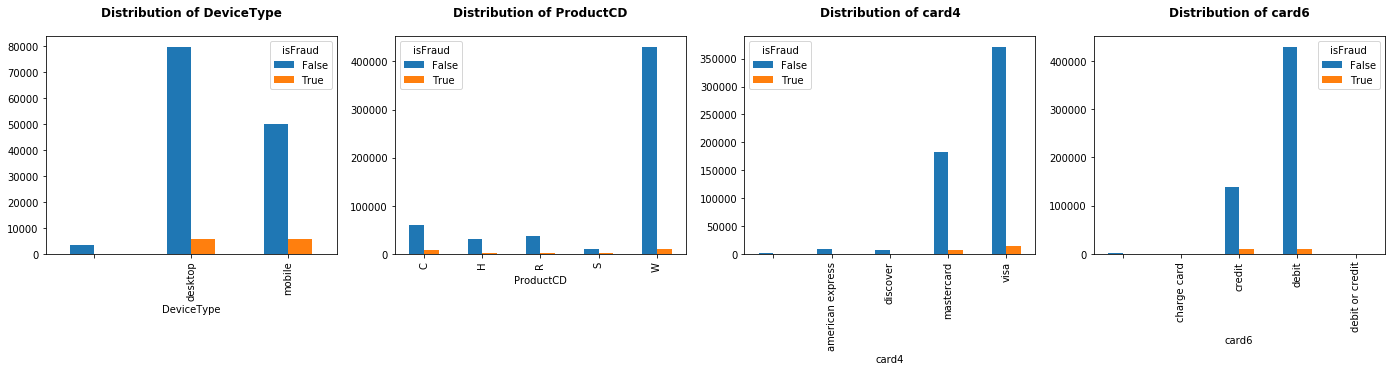

In [13]:
# Plot for frequency distribution of categorical values
fig, axes = plt.subplots(1, 4, figsize=(24, 4))

for i, column in enumerate(["DeviceType","ProductCD","card4","card6"]):
    pd.crosstab(trainset[column], trainset.isFraud).plot(kind='bar', ax=axes[i])
    axes[i].set_title("Distribution of " + column, pad=20, fontweight='bold', fontsize=12)

#### Comparing the frequencies of categorical fields for fraudulent and non-fraudulent transactions through [Data Visualization$^{[2]}$](#References):

- `DeviceType`: We can see that fraudulent transactions mostly occur in desktop and mobile devices and not in the empty values for devices. Also the ratio of fraud to non fraud seems higher for mobile device as compared to desktop devices.
- `ProductCD`: This field seems to be highly dominated by product code 'W' and fraudulent transactions mostly seem to appear for product codes 'C' and 'W'.
- `card4`: The dataset again seems to be dominated by Visa and Mastercard values and accordingly we have higher frauds for Visa and Mastercard.
- `card6`: Majority of the transactions are debit card transactions and fraudulent transactions appear both in credit and debit card transactions mostly. Other values have extremely low frequency for this field.

Other categorical fields like `DeviceInfo`, `P_emaildomain` and `R_emaildomain` have very large number of unique values and do not provide much insight for the dataset. Example values for the field `DeviceInfo` for both fraud and non fraud transactions are as below having similar characteristics:

In [14]:
trainset.groupby('isFraud')['DeviceInfo'].value_counts()

isFraud  DeviceInfo                    
False    Windows                           44601
                                           22856
         iOS Device                        18542
         MacOS                             12295
         Trident/7.0                        7344
         rv:11.0                            1825
         rv:57.0                             859
         SM-J700M Build/MMB29K               489
         SM-G610M Build/MMB29K               424
         SM-G531H Build/LMY48B               377
         rv:59.0                             318
         SM-G532M Build/MMB29T               304
         SM-G935F Build/NRD90M               303
         SM-G955U Build/NRD90M               295
         ALE-L23 Build/HuaweiALE-L23         283
         SM-G930V Build/NRD90M               274
         SM-G950U Build/NRD90M               274
         rv:52.0                             244
         SAMSUNG                             230
         rv:58.0             

## Part 2 - Transaction Frequency

In [2]:
# Create dataset containing entries for only the most frequently occuring country code in addr2
most_freq_country_code = trainset['addr2'].value_counts().idxmax()
print('Most frequent country code: {}'.format(most_freq_country_code))
addr2_set = trainset[trainset['addr2'] == most_freq_country_code]

Text(0, 0.5, 'Number of Transactions')

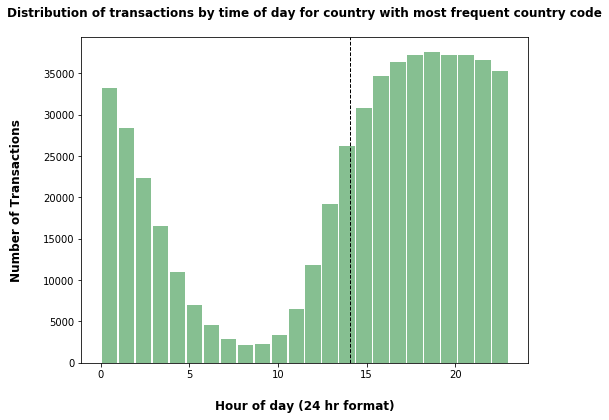

In [18]:
# Histogram of hour of the day
hist = addr2_set['TransactionDT_hour'].hist(bins=24, grid=False, figsize=(8,6), color='#86bf91', zorder=2, rwidth=0.9)
hist.axvline(addr2_set['TransactionDT_hour'].mean(), color='k', linestyle='dashed', linewidth=1)

hist.set_title("Distribution of transactions by time of day for country with most frequent country code", pad=20, fontweight='bold', fontsize=12)

hist.set_xlabel("Hour of day (24 hr format)", labelpad=20, weight='bold', size=12)
hist.set_ylabel("Number of Transactions", labelpad=20, weight='bold', size=12)

#### From the above distribution of transactions for hour of the day for the most frequent country code, we can infer a few things:

- The transactions show a cyclic pattern across the day. This is true because hour of the day goes from 0 to 23 and then back to 0 following a cyclic pattern as well. 
- It can also be observed that the frequency of transactions is high during certain hours and low during other hours. This can be explained by the fact that most transactions occur during daytime and only a few transactions occur at night.
- We can see that the transactions are lowest at 8th and 9th hour and start to increase after 10th hour. Assuming that transactions are lowest after midnight and start increasing after waking hours i.e. sunrise (6 am), we can map 10th hour of the dataset to 6 am and can deduce the timezone to be roughly around -4:00 UTC which suggests that this area code belongs to western countries.

## Part 3 - Product Code

In [3]:
# TODO: code to analyze prices for different product codes

Write your answer here

## Part 4 - Correlation Coefficient

In [4]:
# TODO: code to calculate correlation coefficient

Write your answer here

## Part 5 - Interesting Plot

In [5]:
# TODO: code to generate the plot here.

Write your answer here

## Part 6 - Prediction Model

In [6]:
# TODO: code for your final model

Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING

References
----------

1. histograms - https://mode.com/example-gallery/python_histogram/  
1. data visualization - https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
1. logistic regression - https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8  
1. cyclical features - http://blog.davidkaleko.com/feature-engineering-cyclical-features.html  
1. data cleaning - https://docs.google.com/presentation/d/12Oqzl6aqFtCncrZlUO-82prtiofQt46q-79gzb_nTEA/edit#slide=id.g1187521ab4_0_125
1. undersampling - https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8
1. oversampling - https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879
1. saving a model - https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
1. xgboost - https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/